# Anime Recommendation System
 

<img src="https://miro.medium.com/max/1400/1*nFQqETyMOcItF_0IasBcfw.jpeg" style="width: 100%; height: 100%" align = "left">


# Table of contents

[<h3> 1. Exploratory data analysis and data cleaning</h3>](#1)

[<h3>2. Collaborative Recommendation System</h3>](#2)

[<h3>3. Recommendations</h3>](#3)

   [<h4>3.1. Naruto</h4>](#4)

  

In the notebook we will build a basic anime collaborative recommendation system. First of all let's have a look at the dataset.

This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings. Its composition in numbers: 
* 20.000.000 ratings
* 460.000 tags
* 27.000 movies

<h2> Content:</h2>

**Anime.csv that contains ratings of movies by users:**
* **anime_id** - myanimelist.net's unique id identifying an anime.
* **name** - full name of anime.
* **genre** - comma separated list of genres for this anime.
* **type** - movie, TV, OVA, etc.
* **episodes** - how many episodes in this show. (1 if movie).
* **rating** - average rating out of 10 for this anime.
* **members** - number of community members that are in this anime's
"group".

**Rating.csv that contains movie information:**
* **user_id** - non identifiable randomly generated user id.
* **anime_id** - the anime that this user has rated.
* **rating** - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).





# 1. Exploratory data analysis and data cleaning<a class="anchor" id="1"></a>



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
anime = pd.read_csv('anime dataset.csv')
rating = pd.read_csv('rating.csv')

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [6]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [7]:
# Lets have a look the distribution of ratings, because those "-1" are suspicious
rating.rating.value_counts()

 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

I'm not sure what the "-1" mean because the ratings goes from 1 up to 10. Maybe it means, that no rating are available. Therefore we will delete the row with "-1" in rating

In [8]:
# I'm not sure what the "-1" mean because the ratings goes from 1 up to 10. 
# Maybe it means, that no rating are available. 
# Therefore we will delete the rows with "-1" in rating
rating = rating[rating["rating"] != -1]

In [9]:
print(f"anime.csv - rows: {anime.shape[0]}, columns: {anime.shape[1]}")
print(f"rating.csv - rows: {rating.shape[0]}, columns: {rating.shape[1]}")

anime.csv - rows: 12294, columns: 7
rating.csv - rows: 6337241, columns: 3


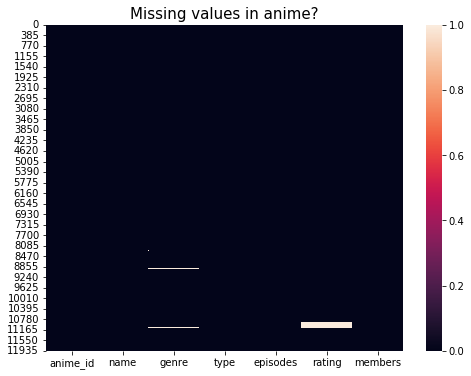

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(anime.isnull())
plt.title("Missing values in anime?", fontsize = 15)
plt.show()

The anime dataset has some missing values in rating and genre, but we can ignore them, because we won't use those columns later.

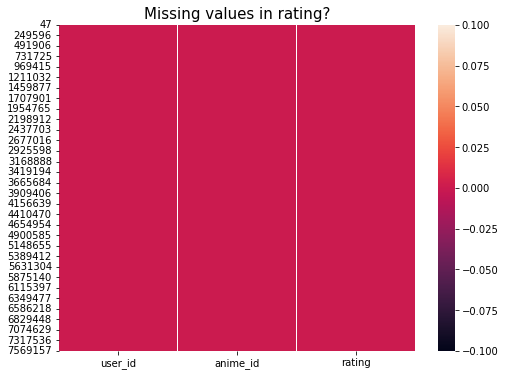

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(rating.isnull())
plt.title("Missing values in rating?", fontsize = 15)
plt.show()

## 1.1. Prepare the data

In [12]:
# Merge anime and rating using "anime_id" as reference
# Keep only the columns we will use
df = pd.merge(rating,anime[["anime_id","name"]], left_on = "anime_id", right_on = "anime_id").drop("anime_id", axis = 1)
df.head()

,user_id,rating,name
0,1,10,Highschool of the Dead
1,3,6,Highschool of the Dead
2,5,2,Highschool of the Dead
3,12,6,Highschool of the Dead
4,14,6,Highschool of the Dead


In [13]:
# count the rating for each anime
count_rating = df.groupby("name")["rating"].count().sort_values(ascending = False)
count_rating

name
Death Note                         34226
Sword Art Online                   26310
Shingeki no Kyojin                 25290
Code Geass: Hangyaku no Lelouch    24126
Angel Beats!                       23565
                                   ...  
Ashita no Eleventachi                  1
Ashita e Mukau Hito                    1
Shounen Ninja Kaze no Fujimaru         1
Hi no Tori: Hagoromo-hen               1
Mechakko Dotakon                       1
Name: rating, Length: 9926, dtype: int64

In [14]:
# Some animes have only 1 rating, therefore it is better for the recommender system to ignore them
# We will keep only the animes with at least r ratings
r = 5000
more_than_r_ratings = count_rating[count_rating.apply(lambda x: x >= r)].index

# Keep only the animes with a least r ratings in the DataFrame
df_r = df[df['name'].apply(lambda x: x in more_than_r_ratings)]

In [15]:
before = len(df.name.unique())
after = len(df_r.name.unique())
rows_before = df.shape[0]
rows_after = df_r.shape[0]
print(f'''There are {before} animes in the dataset before filtering and {after} animes after the filtering.

{before} animes => {after} animes
{rows_before} rows before filtering => {rows_after} rows after filtering''')

There are 9926 animes in the dataset before filtering and 279 animes after the filtering.

9926 animes => 279 animes
6337239 rows before filtering => 2517097 rows after filtering


# 2. Collaborative Recommendation System<a class="anchor" id="2"></a>

In [16]:
# Create a matrix with userId as rows and the titles of the movies as column.
# Each cell will have the rating given by the user to the animes.
# There will be a lot of NaN values, because each user hasn't watched most of the animes
df_recom = df_r.pivot_table(index='user_id',columns='name',values='rating')
df_recom.iloc[:5,:5]

name,Accel World,Afro Samurai,Air,Air Gear,Akame ga Kill!
user_id,,,,,
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,7.0,6.0,NaN,NaN,8.0
5,3.0,NaN,NaN,NaN,4.0
7,8.0,NaN,NaN,NaN,NaN


In [17]:
df_r.name.value_counts().head(10)

Death Note                            34226
Sword Art Online                      26310
Shingeki no Kyojin                    25290
Code Geass: Hangyaku no Lelouch       24126
Angel Beats!                          23565
Elfen Lied                            23528
Naruto                                22071
Fullmetal Alchemist: Brotherhood      21494
Fullmetal Alchemist                   21332
Code Geass: Hangyaku no Lelouch R2    21124
Name: name, dtype: int64

In [18]:
def find_corr(df, name):
    '''
    Get the correlation of one anime with the others
    
    Args
        df (DataFrame):  with user_id as rows and movie titles as column and ratings as values
        name (str): Name of the anime
    
    Return
        DataFrame with the correlation of the anime with all others
    '''
    
    similar_to_movie = df.corrwith(df[name])
    similar_to_movie = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    similar_to_movie = similar_to_movie.sort_values(by = 'Correlation', ascending = False)
    return similar_to_movie

# 3. Recommendations <a class="anchor" id="3"></a>

Let's try the recommendation system on three animes.

* The higher the correlation, the higher the possibility that the viewer of the selected anime will like the recommended anime
* Negative correlation means that the viewer is likely to dislikes the anime

## 3.1. [Naruto](https://en.wikipedia.org/wiki/Naruto)<a class="anchor" id="4"></a>
<img src="https://upload.wikimedia.org/wikipedia/en/9/94/NarutoCoverTankobon1.jpg" style="width: 20%; height: 20%" align = "left">


In [18]:
# Let's choose an anime
anime1 = 'Naruto'

# Let's try with "Naruto"

# Recommendations
find_corr(df_recom, anime1).head(40)

,Correlation
name,
Naruto,1.000000
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!,0.582344
Naruto: Shippuuden Movie 1,0.578797
Bleach,0.547983
Fairy Tail,0.444271
Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru,0.439225
Dragon Ball Z,0.437442
InuYasha,0.433100
Dragon Ball GT,0.429704


In [19]:
# Not recommended
find_corr(df_recom, anime1).tail(40)

,Correlation
name,
"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen",0.168322
School Days,0.167049
Gekkan Shoujo Nozaki-kun,0.165715
Usagi Drop,0.164647
Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku,0.164441
Tenkuu no Shiro Laputa,0.164389
Higurashi no Naku Koro ni,0.157723
Steins;Gate,0.156113
Ookami to Koushinryou II,0.154742
